## An example how to calculate SDG 11.2 indicator for Friedrichshain (Berlin)

This is an example on how to calculate the SDG11.2.1 indicator for the district of Friedrichshain in Berlin (Germany).
We start by importing all necessary libraries and setting our project path to the system paths.

In [18]:
import os
import sys
import pandas as pd
project_path = os.path.abspath('../')
sys.path.append(project_path)
import geopandas as gpd
from matplotlib import pyplot as plt
from ptac import accessibility as accessibility
from ptac import osm as osm
from ptac import population as population

Next, we have to load public transport stops and population data.

In [2]:
stops = gpd.read_file(project_path + "/data/friedrichshain_pt.gpkg")
population_points = gpd.read_file(project_path + "/data/friedrichshain_population.gpkg")

You might want to generate a boundary of the population dataset using the convex hull function of geopandas.
The boundary is necessary as a bounding box to download the road network.

<AxesSubplot:>

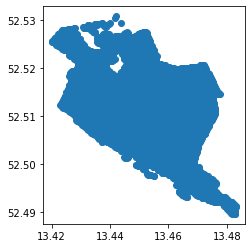

In [3]:
boundary_gdf = gpd.GeoDataFrame(index=[0], crs='epsg:4326', geometry=[population_points.unary_union])

boundary_gdf.plot()

if you have population data in a raster format you might want to convert this raster to a point geodataframe from
which you can start the accessibility calculation. You will be able to download raster population information from the
world settlement footprint in the future. We hope this functionality will be available until autumn 2021.

In [4]:
population_points = population.raster_to_points(path=project_path + "/data/friedrichshain_population_raster.tif")

Now, we plot population and pt stops

<AxesSubplot:>

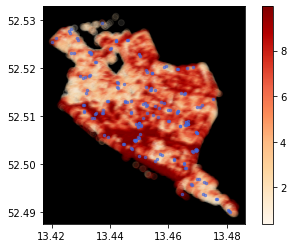

In [5]:
ax = population_points.plot(column= "pop", cmap='OrRd', legend=True, alpha=0.1)
ax.set_facecolor("black")
stops.plot(color="royalblue", ax=ax, markersize=6, alpha=0.6)

Calculate sum of population in the focus area

In [6]:
population_sum = population_points["pop"].sum()

print(f"Overall sum of population is: {population_sum}")

Overall sum of population is: 88270.7109375


Now calculate the accessibility from population point data to stations. If you do not pass a network_gdf dataset
, it will be downloaded automatically based on the bounding box.

In [7]:
accessibility_output = accessibility.distance_to_closest(start_geometries=population_points,
                                  destination_geometries=stops,
                                  boundary_geometries=boundary_gdf,
                                  network_gdf=None,
                                  number_of_threads=4,
                                  verbose=1)

No street network was specified. Loading osm network..

Preparing street network for routing
Starting UrMoAC to calculate accessibilities

calculation finished in 26.5121404 seconds


the output looks like this:

In [8]:
accessibility_output.head(5)

,index,pop,x_coord,y_coord,geometry,x,y,o_id,d_id,distance_pt
0,0,1.889245,13.441986,52.530828,POINT (394314.570 5821221.644),394314.570441,5.821222e+06,0.0,76.0,451.52
1,1,2.585283,13.441716,52.530558,POINT (394295.644 5821192.064),394295.643702,5.821192e+06,1.0,76.0,438.33
2,2,6.065472,13.437135,52.529480,POINT (393982.293 5821078.889),393982.292943,5.821079e+06,2.0,76.0,0.92
3,3,6.065472,13.437404,52.529480,POINT (394000.573 5821078.493),394000.573062,5.821078e+06,3.0,76.0,52.70
4,4,1.988679,13.440099,52.529480,POINT (394183.374 5821074.539),394183.374284,5.821075e+06,4.0,76.0,392.76


It is also possible to download the network before calculating

In [9]:
network_gdf = osm.get_network(boundary_gdf)

Then, we can have a look at the network..

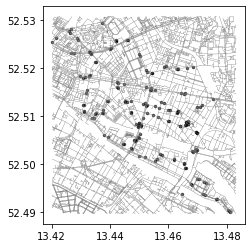

In [10]:
ax = stops.plot(color="black", markersize=6, alpha=0.6)
network_gdf.plot(color="grey", linewidth=0.2, ax=ax)
plt.show()

.. and store it to disk. You are able to drag and drop this data set into your GIS software.

In [11]:
network_gdf.to_file(project_path + "/data/friedrichshain_network.gpkg", driver="GPKG")

Now, we can calculate again with our stored network.

In [12]:
network_gdf = gpd.read_file(project_path + "/data/friedrichshain_network.gpkg")

accessibility_output= accessibility.distance_to_closest(start_geometries=population_points,
                                  destination_geometries=stops,
                                  boundary_geometries=boundary_gdf,
                                  maximum_distance=500,
                                  network_gdf=network_gdf,
                                  verbose=1)

Street network provided

Preparing street network for routing
Starting UrMoAC to calculate accessibilities

calculation finished in 14.205772699999997 seconds


Setting maximum distance to 500 meters generates an output in
which only includes starting points which are within 500 meters from the next station.

In [13]:
accessibility_output.head(5)

,index,pop,x_coord,y_coord,geometry,x,y,o_id,d_id,distance_pt
0,0,1.889245,13.441986,52.530828,POINT (394314.570 5821221.644),394314.570441,5.821222e+06,0.0,76.0,451.52
1,1,2.585283,13.441716,52.530558,POINT (394295.644 5821192.064),394295.643702,5.821192e+06,1.0,76.0,438.33
2,2,6.065472,13.437135,52.529480,POINT (393982.293 5821078.889),393982.292943,5.821079e+06,2.0,76.0,0.92
3,3,6.065472,13.437404,52.529480,POINT (394000.573 5821078.493),394000.573062,5.821078e+06,3.0,76.0,52.70
4,4,1.988679,13.440099,52.529480,POINT (394183.374 5821074.539),394183.374284,5.821075e+06,4.0,76.0,392.76


Calculate sum of population with access to pt within 500 meters

In [14]:
sum_pop_with_access = accessibility_output["pop"].sum()
print(sum_pop_with_access)

84678.95


Calculate the actual indicator and print the result

In [15]:
sdg = accessibility.calculate_sdg(df_pop_total=population_points,
                                  pop_accessible=accessibility_output,
                                  population_column='pop')
print(f"{sdg} percent of the population have access to the public transit system within 500 meters")


Calculating SDG 11.2. indicator ... 
SDG 11.2.1 indicator is calculated
0.9593097567558289 percent of the population have access to the public transit system within 500 meters


Plot result as a map

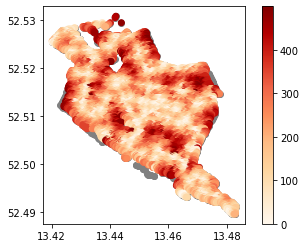

In [16]:
ax = population_points.to_crs(4326).plot(color="grey")
accessibility_output.to_crs(4326).plot(column='distance_pt', cmap='OrRd', ax=ax, legend=True)
plt.show()

If you wish to differentiate between high- and low-capacity public transport you should split the
dataset in. This is an example how to do it. Might be different in your case based on the structure of your dataset. However, according to SDG Indicator metadata; low-capacity public transport systems are bus, Bus Rapid 
Transit and high-capacity systems are rail, metro, ferry.

In [11]:
stops_low_capacity = stops[stops["highway"]=="bus_stop"]
stops_high_capacity = stops[(stops["railway"]=="tram_stop")|(stops["railway"]=="station")]
stops_low_capacity.to_file(project_path + "/data/friedrichshain_stops_low_capacity.gpkg")
stops_high_capacity.to_file(project_path + "/data/friedrichshain_stops_high_capacity.gpkg")

Now, we have to run accessibility calculation for high and low capacity public transport

In [12]:
network_gdf = gpd.read_file(project_path + "/data/friedrichshain_network.gpkg")

accessibility_output_low = accessibility.distance_to_closest(start_geometries=population_points,
                                  destination_geometries=stops_low_capacity,
                                  transport_system="low-capacity",
                                  boundary_geometries=boundary_gdf,
                                  network_gdf=network_gdf,
                                  verbose=1)


accessibility_output_high = accessibility.distance_to_closest(start_geometries=population_points,
                                  destination_geometries=stops_high_capacity,
                                  transport_system="high-capacity",
                                  boundary_geometries=boundary_gdf,
                                  network_gdf=network_gdf,
                                  verbose=1)

Street network provided

Preparing street network for routing
Starting UrMoAC to calculate accessibilities

calculation finished in 12.022355799999985 seconds
Street network provided

Preparing street network for routing
Starting UrMoAC to calculate accessibilities

calculation finished in 13.250177500000007 seconds


Combine low- and high-capacity pt systems accessibility outputs:

In [19]:
accessibility_output = pd.concat([accessibility_output_low, accessibility_output_high])
accessibility_output = accessibility_output.drop_duplicates(subset=['index', 'o_id'])

Plot accessibility outputs and pt stops on a map:

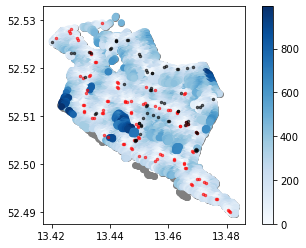

In [30]:
ax = boundary_gdf.plot(color="grey")
accessibility_output.to_crs(4326).plot(column='distance_pt', cmap='Blues', ax=ax, legend=True)
stops_low_capacity.plot(c='red',  markersize=6, alpha=0.6, ax=ax)
stops_high_capacity.plot(c='black',  markersize=6, alpha=0.6, ax=ax)
plt.show()

.. and calculate the actual SDG indicator out of that. As assumed, the value is a bit higher, now.

In [13]:
sdg_low_high = accessibility.calculate_sdg(df_pop_total=population_points,
                                           pop_accessible=[accessibility_output_high, accessibility_output_low],
                                           population_column='pop')
print(f"{sdg_low_high} percent of the population have access to low- and high-capacity public transit systems")


SDG 11.2.1 indicator is calculated
0.9867684841156006 percent of the population have access to low- and high-capacity public transit systems


In [20]:
accessibility_output_low.to_file(project_path + "/data/friedrichshain_accessibility_output_low.gpkg")
accessibility_output_high.to_file(project_path + "/data/friedrichshain_accessibility_output_high.gpkg")